# Batik Classification using CNN

## Directory check

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/

/content/gdrive/MyDrive


In [3]:
import os
for dirpath, dirnames, filenames in os.walk("data_klasifikasi_batik"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} files in {dirpath}")

There are 2 directories and 0 files in data_klasifikasi_batik
There are 6 directories and 0 files in data_klasifikasi_batik/test
There are 0 directories and 10 files in data_klasifikasi_batik/test/Lereng
There are 0 directories and 10 files in data_klasifikasi_batik/test/Nitik
There are 0 directories and 10 files in data_klasifikasi_batik/test/Parang
There are 0 directories and 10 files in data_klasifikasi_batik/test/Mix motif
There are 0 directories and 10 files in data_klasifikasi_batik/test/Ceplok
There are 0 directories and 10 files in data_klasifikasi_batik/test/Kawung
There are 6 directories and 0 files in data_klasifikasi_batik/train
There are 0 directories and 89 files in data_klasifikasi_batik/train/Kawung
There are 0 directories and 132 files in data_klasifikasi_batik/train/Ceplok
There are 0 directories and 165 files in data_klasifikasi_batik/train/Parang
There are 0 directories and 52 files in data_klasifikasi_batik/train/Lereng
There are 0 directories and 110 files in data

## Sample data check

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  target_folder = target_dir + target_class

  # Take 1 sample
  random_image = random.sample(os.listdir(target_folder), 1)

  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Picture size: {img.shape}")
  return img

Picture size: (500, 500, 3)


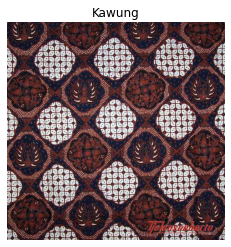

In [5]:
img = view_random_image("data_klasifikasi_batik/train/", "Kawung")

Note to self: Some pictures have different sizes like `(1200, 1200, 3)` although the majority size is `(500, 500, 3)`.

## Model building
Let's start by importing many things from Tensorflow and setting the random seed with 3244 thanks to CS3244 ;)

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

In [7]:
tf.random.set_seed(3244)

In [8]:
train_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)

In [9]:
train_dir = "data_klasifikasi_batik/train/"
test_dir = "data_klasifikasi_batik/test/"

In [10]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size = 16,
                                               target_size = (500, 500),
                                               class_mode = "categorical",
                                               seed = 3244)

valid_data = train_datagen.flow_from_directory(test_dir,
                                               batch_size = 16,
                                               target_size = (500, 500),
                                               class_mode = "categorical",
                                               seed = 3244)

Found 580 images belonging to 6 classes.
Found 60 images belonging to 6 classes.


### Model 1
Very simple, but also very prone to overfitting as seen in the loss and accuracy curve.

In [11]:
model_1 = Sequential([
                      Conv2D(10, 3, activation = 'relu'), # 10 filters, 3x3 kernel size
                      MaxPool2D(2),
                      Conv2D(10, 3, activation = 'relu'), # 10 filters, 3x3 kernel size
                      MaxPool2D(2),
                      Flatten(),
                      Dense(6, activation = 'softmax') # 6 classes
])

In [12]:
model_1.compile(loss = 'categorical_crossentropy',
                optimizer = Adam(),
                metrics = ['accuracy'])

In [13]:
history_1 = model_1.fit(train_data,
                        epochs = 10, # probably try 30 to check overfit also
                        steps_per_epoch = len(train_data),
                        validation_data = valid_data,
                        validation_steps = len(valid_data))

Epoch 1/10
37/37 [==============================] - 204s 5s/step - loss: 4.9556 - accuracy: 0.2690 - val_loss: 1.8222 - val_accuracy: 0.2167
Epoch 2/10
37/37 [==============================] - 8s 223ms/step - loss: 1.5367 - accuracy: 0.3845 - val_loss: 1.8407 - val_accuracy: 0.2333
Epoch 3/10
37/37 [==============================] - 8s 219ms/step - loss: 1.1515 - accuracy: 0.6328 - val_loss: 2.0207 - val_accuracy: 0.3333
Epoch 4/10
37/37 [==============================] - 8s 218ms/step - loss: 0.7842 - accuracy: 0.7810 - val_loss: 1.8705 - val_accuracy: 0.3167
Epoch 5/10
37/37 [==============================] - 8s 219ms/step - loss: 0.5752 - accuracy: 0.8500 - val_loss: 2.4100 - val_accuracy: 0.3833
Epoch 6/10
37/37 [==============================] - 8s 215ms/step - loss: 0.4899 - accuracy: 0.8741 - val_loss: 2.0466 - val_accuracy: 0.3833
Epoch 7/10
37/37 [==============================] - 8s 222ms/step - loss: 0.4645 - accuracy: 0.8655 - val_loss: 2.1143 - val_accuracy: 0.3833
Epoch 8

In [14]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(len(history.history['loss']))
  
  plt.plot(epochs, loss, label = "Training loss")
  plt.plot(epochs, val_loss, label = "Validation loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label = "Training accuracy")
  plt.plot(epochs, val_accuracy, label = "Validation accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

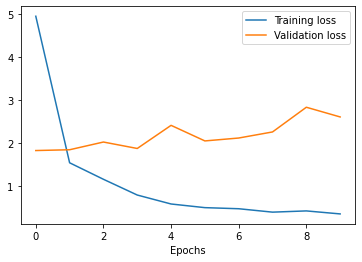

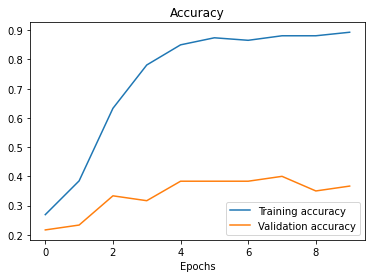

In [15]:
plot_loss_curves(history_1)

### Model 2: Data Augmentation
We'll see if data augmentation can reduce overfitting...

In [16]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   horizontal_flip = True)
valid_datagen = ImageDataGenerator(rescale = 1./255)

In [17]:
train_data_augmented = train_datagen.flow_from_directory(train_dir,
                                                         batch_size = 16,
                                                         target_size = (500, 500),
                                                         class_mode = "categorical",
                                                         shuffle = True)

Found 580 images belonging to 6 classes.


This is just a copy fromm `model_1`.

In [18]:
model_2 = Sequential([
                      Conv2D(10, 3, activation = 'relu'), # 10 filters, 3x3 kernel size
                      MaxPool2D(2),
                      Conv2D(10, 3, activation = 'relu'), # 10 filters, 3x3 kernel size
                      MaxPool2D(2),
                      Flatten(),
                      Dense(6, activation = 'softmax') # 6 classes
])

model_2.compile(loss = 'categorical_crossentropy',
                optimizer = Adam(),
                metrics = ['accuracy'])

history_2 = model_2.fit(train_data_augmented,
                        epochs = 10, # probably try 30 to check overfit also
                        steps_per_epoch = len(train_data),
                        validation_data = valid_data,
                        validation_steps = len(valid_data))

Epoch 1/10
37/37 [==============================] - 37s 983ms/step - loss: 2.5352 - accuracy: 0.2569 - val_loss: 1.9655 - val_accuracy: 0.1500
Epoch 2/10
37/37 [==============================] - 36s 983ms/step - loss: 1.6714 - accuracy: 0.2914 - val_loss: 1.9439 - val_accuracy: 0.1667
Epoch 3/10
37/37 [==============================] - 37s 985ms/step - loss: 1.6479 - accuracy: 0.3345 - val_loss: 1.9453 - val_accuracy: 0.1667
Epoch 4/10
37/37 [==============================] - 37s 986ms/step - loss: 1.6315 - accuracy: 0.3431 - val_loss: 1.9217 - val_accuracy: 0.2167
Epoch 5/10
37/37 [==============================] - 37s 989ms/step - loss: 1.6354 - accuracy: 0.3500 - val_loss: 1.7495 - val_accuracy: 0.3000
Epoch 6/10
37/37 [==============================] - 37s 989ms/step - loss: 1.6148 - accuracy: 0.3517 - val_loss: 1.9181 - val_accuracy: 0.2667
Epoch 7/10
37/37 [==============================] - 37s 996ms/step - loss: 1.5830 - accuracy: 0.3845 - val_loss: 1.9173 - val_accuracy: 0.2667

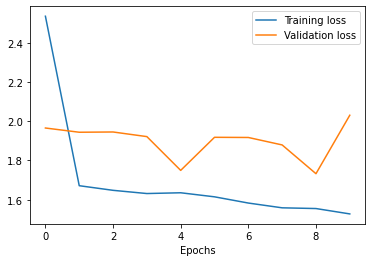

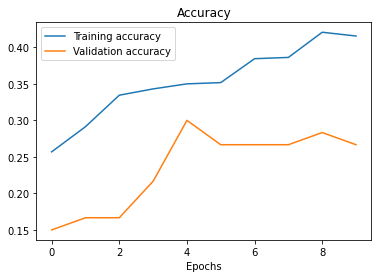

In [19]:
plot_loss_curves(history_2)

Seems better, but the accuracies are much lower. Can we do better?

### Model 3: Increase batch size
Optionally, we can change `batch_size` to 64 and `target_size` to `(450, 450)`.

In [20]:
train_data_augmented = train_datagen.flow_from_directory(train_dir,
                                                         batch_size = 32,
                                                         target_size = (500, 500),
                                                         class_mode = "categorical",
                                                         shuffle = True)

Found 580 images belonging to 6 classes.


In [21]:
model_3 = Sequential([
                      Conv2D(50, 3, activation = 'relu'),
                      Conv2D(50, 3, activation = 'relu'),
                      MaxPool2D(2),
                      Conv2D(50, 3, activation = 'relu'),
                      Conv2D(50, 3, activation = 'relu'),
                      MaxPool2D(2),
                      Flatten(),
                      Dense(6, activation = 'softmax') # 6 classes
])

model_3.compile(loss = 'categorical_crossentropy',
                optimizer = Adam(),
                metrics = ['accuracy'])

history_3 = model_3.fit(train_data_augmented,
                        epochs = 10,
                        validation_data = valid_data)

Epoch 1/10
19/19 [==============================] - 76s 3s/step - loss: 5.0355 - accuracy: 0.2534 - val_loss: 2.0565 - val_accuracy: 0.1833
Epoch 2/10
19/19 [==============================] - 49s 3s/step - loss: 1.6999 - accuracy: 0.2948 - val_loss: 2.1795 - val_accuracy: 0.2667
Epoch 3/10
19/19 [==============================] - 48s 3s/step - loss: 1.7526 - accuracy: 0.2241 - val_loss: 2.2903 - val_accuracy: 0.2000
Epoch 4/10
19/19 [==============================] - 49s 3s/step - loss: 1.6943 - accuracy: 0.2759 - val_loss: 2.0320 - val_accuracy: 0.1500
Epoch 5/10
19/19 [==============================] - 49s 3s/step - loss: 1.7145 - accuracy: 0.2759 - val_loss: 2.3841 - val_accuracy: 0.2167
Epoch 6/10
19/19 [==============================] - 49s 3s/step - loss: 1.7147 - accuracy: 0.2500 - val_loss: 1.8104 - val_accuracy: 0.2500
Epoch 7/10
19/19 [==============================] - 49s 3s/step - loss: 1.6825 - accuracy: 0.2931 - val_loss: 1.8403 - val_accuracy: 0.3000
Epoch 8/10
19/19 [==

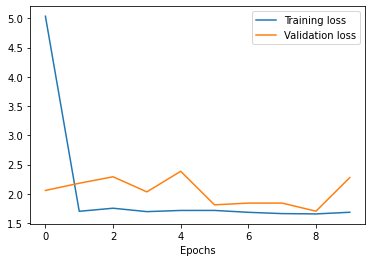

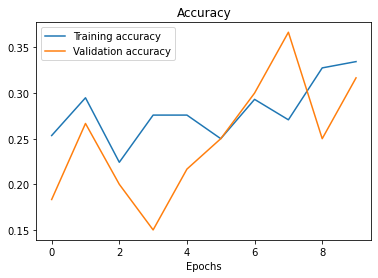

In [22]:
plot_loss_curves(history_3)

## Model 4: Using MobileNetV2
Hearsay it's better than the plain CNN in general. Although we don't have that many data, hopefully it does better than Model 3.

In [23]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape = (450, 450, 3),
                                                            include_top = False,
                                                            weights = "imagenet")

9420800/9406464 [==============================] - 0s 0us/step


In [24]:
base_model.trainable = False

In [25]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = Dense(6)
soft = Activation('softmax')

inputs = tf.keras.Input(shape = (450, 450, 3))
x = base_model(inputs, training = False)
x = global_average_layer(x)
x = Dropout(0.2)(x)
outputs = prediction_layer(x)
outputs = soft(outputs)

model_4 = tf.keras.Model(inputs, outputs)
model_4.compile(loss = 'categorical_crossentropy',
                optimizer = Adam(),
                metrics = ['accuracy'])

history_4 = model_4.fit(train_data_augmented,
                        epochs = 10,
                        validation_data = valid_data)

Epoch 1/10
19/19 [==============================] - 45s 2s/step - loss: 1.7235 - accuracy: 0.3172 - val_loss: 1.7951 - val_accuracy: 0.3167
Epoch 2/10
19/19 [==============================] - 38s 2s/step - loss: 1.3625 - accuracy: 0.4724 - val_loss: 1.4984 - val_accuracy: 0.4500
Epoch 3/10
19/19 [==============================] - 38s 2s/step - loss: 1.2171 - accuracy: 0.5500 - val_loss: 1.4162 - val_accuracy: 0.5167
Epoch 4/10
19/19 [==============================] - 38s 2s/step - loss: 1.1195 - accuracy: 0.6155 - val_loss: 1.3530 - val_accuracy: 0.5000
Epoch 5/10
19/19 [==============================] - 38s 2s/step - loss: 1.0537 - accuracy: 0.6224 - val_loss: 1.3636 - val_accuracy: 0.5000
Epoch 6/10
19/19 [==============================] - 38s 2s/step - loss: 0.9846 - accuracy: 0.6379 - val_loss: 1.3830 - val_accuracy: 0.5000
Epoch 7/10
19/19 [==============================] - 38s 2s/step - loss: 0.9495 - accuracy: 0.6569 - val_loss: 1.4256 - val_accuracy: 0.4667
Epoch 8/10
19/19 [==

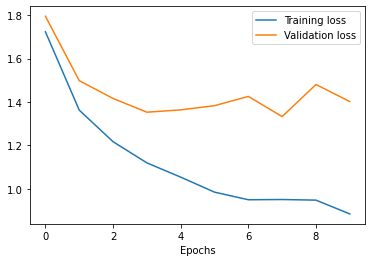

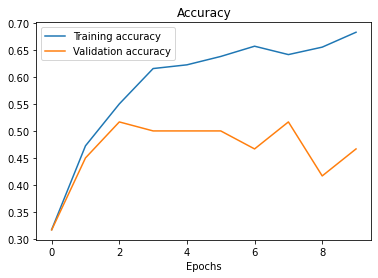

In [26]:
plot_loss_curves(history_4)

And yes, that was the end of the livestream :)